In [1]:
import pandas as pd
import numpy as np
from pickleshare import PickleShareDB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import time
import tracemalloc

In [2]:
# Pour garantir la reproductibilité
np.random.seed(42)  # Pour numpy

## Chargement des données

In [3]:
db = PickleShareDB('../prep_data/kity')

In [4]:
# Chargement des données de classification binaire
X_train_resampled_binary = db['binary_X_train_resampled']
y_train_resampled_binary = db['binary_y_train_resampled']
X_test_binary = db['binary_X_test']
y_test_binary = db['binary_y_test']

# Chargement des données de classification multi-classes
X_train_resampled_multiclass = db['multiclass_X_train_resampled']
y_train_resampled_multiclass = db['multiclass_y_train_resampled']
X_test_multiclass = db['multiclass_X_test']
y_test_multiclass = db['multiclass_y_test']

# Chargement du mapping des étiquettes pour la classification multi-classes
# Ce dictionnaire associe les étiquettes textuelles (e.g., 'normal', 'DoS') à des valeurs numériques
label_mapping_network = db['label_mapping_network'] 

## Initialisation du modèle

In [5]:
# Initialiser le modèle CART 
cart = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    random_state=42
)

## Entraînement du modèle et évaluation - Classification binaire

In [6]:
# Mesurer le temps et la mémoire pour l'entraînement
tracemalloc.start()
start_fit_time = time.time()

cart.fit(X_train_resampled_binary, y_train_resampled_binary)

fit_time = time.time() - start_fit_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
fit_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

In [7]:
# Mesurer le temps et la mémoire pour la prediction
tracemalloc.start()
start_predict_time = time.time()

# Prédire les étiquettes sur l'ensemble de test
y_pred = cart.predict(X_test_binary)
predict_time = time.time() - start_predict_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
predict_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

### Évaluation

#### Métriques de classification

In [8]:
cm = confusion_matrix(y_test_binary, y_pred)
TN, FP, FN, TP = cm.ravel()

# Métriques pour les données équilibrées
precision = precision_score(y_test_binary, y_pred, average='binary')
recall = recall_score(y_test_binary, y_pred, average='binary')
tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
accuracy = accuracy_score(y_test_binary, y_pred)

# Métriques pour les données déséquilibrées
f1 = f1_score(y_test_binary, y_pred, average='binary')
balanced_acc = balanced_accuracy_score(y_test_binary, y_pred)
mcc = matthews_corrcoef(y_test_binary, y_pred)

results_CART_label_n = {
    'data': 'NETW',
    'model_type': 'CART',
    'attack_type': 'labeln',
    'confusion_matrix': cm,
    'precision': precision,
    'recall': recall,
    'tnr': tnr,
    'fpr': fpr,
    'accuracy': accuracy,
    'f1': f1,
    'balanced_accuracy': balanced_acc,
    'mcc': mcc,
    'fit_time': fit_time,
    'predict_time': predict_time,
    'fit_memory_usage': fit_memory_usage,
    'predict_memory_usage': predict_memory_usage
}

In [9]:
# Afficher les résultats
print("Évaluation complète du modèle:")
for metric, value in results_CART_label_n.items():
    print(f"{metric}: {value}")

Évaluation complète du modèle:
data: NETW
model_type: CART
attack_type: labeln
confusion_matrix: [[62308  1172]
 [18269 26061]]
precision: 0.9569639775272647
recall: 0.587886307241146
tnr: 0.9815374921235035
fpr: 0.018462507876496535
accuracy: 0.8196734996753547
f1: 0.7283372692592541
balanced_accuracy: 0.7847118996823248
mcc: 0.6448365554893828
fit_time: 1.5520477294921875
predict_time: 0.018562793731689453
fit_memory_usage: 34.90293025970459
predict_memory_usage: 5.043912887573242


##### Matrice de confusion 

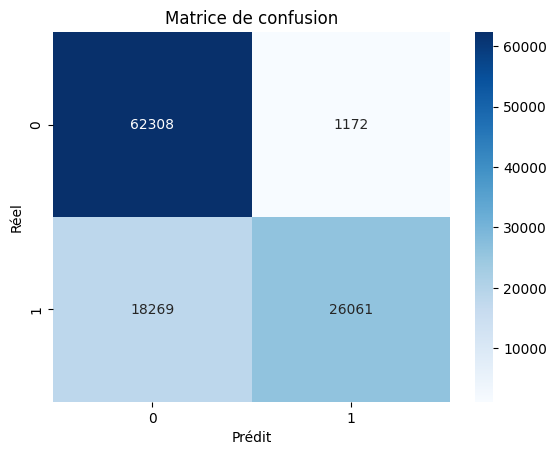

In [10]:
# Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Sauvegarder les resultats

In [11]:
# sauvegarder dans PickleShareDB
db['NETW_results_CART_labeln'] = results_CART_label_n

## Entraînement du modèle et évaluation - Classification multi-classes

In [12]:
nb_class = 5
ordered_classes = ['normal', 'DoS', 'physical fault', 'MITM', 'anomaly']

In [13]:
# Mesurer le temps et la mémoire pour l'entraînement
tracemalloc.start()
start_fit_time = time.time()

cart.fit(X_train_resampled_multiclass, y_train_resampled_multiclass)

fit_time = time.time() - start_fit_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
fit_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

In [14]:
# Mesurer le temps et la mémoire pour la prediction
tracemalloc.start()
start_predict_time = time.time()

# Prédire les étiquettes sur l'ensemble de test
y_pred = cart.predict(X_test_multiclass)
predict_time = time.time() - start_predict_time
current, peak = tracemalloc.get_traced_memory()  # Mémoire actuelle et maximale utilisée
predict_memory_usage = peak / (1024 * 1024)  # Convertir en Mo
tracemalloc.stop()

In [15]:
reverse_label_mapping = {v: k for k, v in label_mapping_network.items()}

### Évaluation

#### Métriques de classification

In [16]:
cm = confusion_matrix(y_test_multiclass, y_pred)

# Dictionnaire pour stocker les résultats de chaque classe
class_results = {}

for class_label in range(nb_class):
    # Extraire la matrice de confusion pour la classe spécifique
    TP = cm[class_label, class_label]
    FP = sum(cm[:, class_label]) - TP
    FN = sum(cm[class_label, :]) - TP
    TN = cm.sum() - (TP + FP + FN)

    # Calcul des métriques pour chaque classe
    precision = precision_score(y_test_multiclass, y_pred, average=None)[class_label]
    recall_tpr = recall_score(y_test_multiclass, y_pred, average=None)[class_label]
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = f1_score(y_test_multiclass, y_pred, average=None)[class_label]
    balanced_acc = (recall_tpr + tnr) / 2
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) != 0 else 0


# Stocker les résultats dans le dictionnaire
    class_results[class_label] = {
        'data': 'NETW',
        'model_type': 'CART',
        'attack_type': reverse_label_mapping[class_label],
        'confusion_matrix': cm,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP,
        'precision': precision,
        'recall': recall_tpr,
        'f1': f1,
        'balanced_accuracy': balanced_acc,
        'mcc': mcc,
        'tnr': tnr,
        'fpr': fpr,
        'accuracy': accuracy,
        'fit_time': fit_time,
        'predict_time': predict_time,
        'fit_memory_usage': fit_memory_usage,
        'predict_memory_usage': predict_memory_usage
    }

# Afficher ou enregistrer les résultats pour chaque classe
print(class_results)

{0: {'data': 'NETW', 'model_type': 'CART', 'attack_type': 'normal', 'confusion_matrix': array([[63063,    79,    82,   256,     0],
       [  581, 25217,     6,     3,     1],
       [ 7664,     6,    31,    42,     0],
       [10484,     9,    22,   262,     0],
       [    0,     0,     0,     0,     2]], dtype=int64), 'TN': 25601, 'FP': 18729, 'FN': 417, 'TP': 63063, 'precision': 0.7710167253521126, 'recall': 0.9934310018903592, 'f1': 0.8682058483396663, 'balanced_accuracy': 0.7854702945386829, 'mcc': 0.656547081148103, 'tnr': 0.5775095871870065, 'fpr': 0.42249041281299343, 'accuracy': 0.8224097950097393, 'fit_time': 1.7625586986541748, 'predict_time': 0.021029233932495117, 'fit_memory_usage': 47.055917739868164, 'predict_memory_usage': 7.817577362060547}, 1: {'data': 'NETW', 'model_type': 'CART', 'attack_type': 'DoS', 'confusion_matrix': array([[63063,    79,    82,   256,     0],
       [  581, 25217,     6,     3,     1],
       [ 7664,     6,    31,    42,     0],
       [10484,

In [17]:
# vérif
print(precision_score(y_test_multiclass, y_pred, average=None))
for i in range(nb_class):
    print(f"Résultats pour la classe {i}: {class_results[i]['precision']}")
    print(f"avec calcul : {class_results[i]['TP'] / (class_results[i]['TP'] + class_results[i]['FP'])}")

[0.77101673 0.9962862  0.21985816 0.46536412 0.66666667]
Résultats pour la classe 0: 0.7710167253521126
avec calcul : 0.7710167253521126
Résultats pour la classe 1: 0.9962861996760302
avec calcul : 0.9962861996760302
Résultats pour la classe 2: 0.2198581560283688
avec calcul : 0.2198581560283688
Résultats pour la classe 3: 0.46536412078152756
avec calcul : 0.46536412078152756
Résultats pour la classe 4: 0.6666666666666666
avec calcul : 0.6666666666666666


In [18]:
tp = class_results[1]['TP']
fn = class_results[1]['FN']
print("test tpr", tp / (tp + fn))
print(class_results[1]['recall'])

test tpr 0.9771001239925604
0.9771001239925604


#### Matrice de confusion 

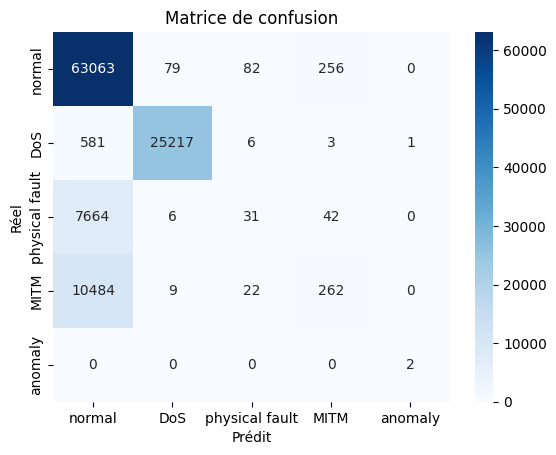

In [19]:
# Matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ordered_classes, yticklabels=ordered_classes)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Sauvegarder les resultats

In [20]:
# sauvegarder les données 

for i in range(1, nb_class):
    class_results[i]['model'] = f'CART - label - {reverse_label_mapping[i]}'
    db[f'NETW_results_CART_{reverse_label_mapping[i]}'] = class_results[i]